# Setting up the environment

First, we are setting up our environment. We use an already compiled and packaged installation of HOOMD-blue and the DLExt plugin.
We copy it from Google Drive and install PySAGES for it.

In [1]:
%%bash

BASE_URL="https://drive.google.com/u/0/uc?id=1hsKkKtdxZTVfHKgqVF6qV2e-4SShmhr7&export=download"
wget -q --load-cookies /tmp/cookies.txt "$BASE_URL&confirm=$(wget -q --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate $BASE_URL -O- | sed -rn 's/.*confirm=(\w+).*/\1\n/p')" -O pysages-env.zip
rm -rf /tmp/cookies.txt

In [2]:
%env PYSAGES_ENV=/env/pysages

env: PYSAGES_ENV=/env/pysages


In [3]:
%%bash

mkdir -p $PYSAGES_ENV .
unzip -qquo pysages-env.zip -d $PYSAGES_ENV

In [4]:
!update-alternatives --auto libcudnn &> /dev/null

In [5]:
import os
import sys

ver = sys.version_info
sys.path.append(os.environ["PYSAGES_ENV"] + "/lib/python" + str(ver.major) + "." + str(ver.minor) + "/site-packages/")

os.environ["XLA_FLAGS"] = "--xla_gpu_strict_conv_algorithm_picker=false"
os.environ["LD_LIBRARY_PATH"] = "/usr/lib/x86_64-linux-gnu:" + os.environ["LD_LIBRARY_PATH"]

## PySAGES

The next step is to install PySAGES.
First, we install the jaxlib version that matches the CUDA installation of this Colab setup. See the JAX documentation [here](https://github.com/google/jax) for more details.

In [6]:
%%bash

pip install -q --upgrade pip
# Installs the wheel compatible with CUDA 11 and cuDNN 8.0.5.
pip install -q --upgrade "jax[cuda11_cudnn805]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html &> /dev/null

Now we can finally install PySAGES. We clone the newest version from [here](https://github.com/SSAGESLabs/PySAGES) and build the remaining pure python dependencies and PySAGES itself.

In [7]:
%%bash

rm -rf PySAGES
git clone https://github.com/SSAGESLabs/PySAGES.git &> /dev/null
cd PySAGES
pip install -q . &> /dev/null

In [8]:
%%bash

mkdir /content/funn
cd /content/funn

# FUNN-biased simulations

FUNN gradually learns the free energy gradient from a discrete estimate based on the same algorithm as the ABF method, but employs a neural network to provide a continuous approximation to it.

For this Colab, we are using butane as the example molecule.

In [9]:
import hoomd
import hoomd.md

import numpy


pi = numpy.pi
kT = 0.596161
dt = 0.02045
mode = "--mode=gpu"


def generate_context(kT = kT, dt = dt, mode = mode):
    """
    Generates a simulation context, we pass this function to the attribute
    `run` of our sampling method.
    """
    hoomd.context.initialize(mode)

    ### System Definition
    snapshot = hoomd.data.make_snapshot(
        N = 14,
        box = hoomd.data.boxdim(Lx = 41, Ly = 41, Lz = 41),
        particle_types = ['C', 'H'],
        bond_types = ["CC", "CH"],
        angle_types = ["CCC", "CCH", "HCH"],
        dihedral_types = ["CCCC", "HCCC", "HCCH"],
        pair_types = ["CCCC", "HCCC", "HCCH"],
        dtype = "double"
    )

    snapshot.particles.typeid[0] = 0
    snapshot.particles.typeid[1:4] = 1
    snapshot.particles.typeid[4] = 0
    snapshot.particles.typeid[5:7] = 1
    snapshot.particles.typeid[7] = 0
    snapshot.particles.typeid[8:10] = 1
    snapshot.particles.typeid[10] = 0
    snapshot.particles.typeid[11:14] = 1

    positions = numpy.array([
        [-2.990196,  0.097881,  0.000091],
        [-2.634894, -0.911406,  0.001002],
        [-2.632173,  0.601251, -0.873601],
        [-4.060195,  0.099327, -0.000736],
        [-2.476854,  0.823942,  1.257436],
        [-2.832157,  1.833228,  1.256526],
        [-2.834877,  0.320572,  2.131128],
        [-0.936856,  0.821861,  1.258628],
        [-0.578833,  1.325231,  0.384935],
        [-0.581553, -0.187426,  1.259538],
        [-0.423514,  1.547922,  2.515972],
        [-0.781537,  1.044552,  3.389664],
        [ 0.646485,  1.546476,  2.516800],
        [-0.778816,  2.557208,  2.515062]
    ])

    reference_box_low_coords = numpy.array([-22.206855, -19.677099, -19.241968])
    box_low_coords = numpy.array([
        -snapshot.box.Lx / 2,
        -snapshot.box.Ly / 2,
        -snapshot.box.Lz / 2
    ])
    positions += (box_low_coords - reference_box_low_coords)

    snapshot.particles.position[:] = positions[:]

    mC = 12.00
    mH = 1.008
    snapshot.particles.mass[:] = [
        mC, mH, mH, mH,
        mC, mH, mH,
        mC, mH, mH,
        mC, mH, mH, mH
    ]

    reference_charges = numpy.array([
        -0.180000, 0.060000, 0.060000, 0.060000,
        -0.120000, 0.060000, 0.060000,
        -0.120000, 0.060000, 0.060000,
        -0.180000, 0.060000, 0.060000, 0.060000]
    )
    charge_conversion = 18.22262
    snapshot.particles.charge[:] = charge_conversion * reference_charges[:]

    snapshot.bonds.resize(13)
    snapshot.bonds.typeid[0:3] = 1
    snapshot.bonds.typeid[3] = 0
    snapshot.bonds.typeid[4:6] = 1
    snapshot.bonds.typeid[6] = 0
    snapshot.bonds.typeid[7:9] = 1
    snapshot.bonds.typeid[9] = 0
    snapshot.bonds.typeid[10:13] = 1

    snapshot.bonds.group[:] = [
        [0, 2], [0, 1], [0, 3], [0, 4],
        [4, 5], [4, 6], [4, 7],
        [7, 8], [7, 9], [7, 10],
        [10, 11], [10, 12], [10, 13]
    ]

    snapshot.angles.resize(24)
    snapshot.angles.typeid[0:2] = 2
    snapshot.angles.typeid[2] = 1
    snapshot.angles.typeid[3] = 2
    snapshot.angles.typeid[4:8] = 1
    snapshot.angles.typeid[8] = 0
    snapshot.angles.typeid[9] = 2
    snapshot.angles.typeid[10:14] = 1
    snapshot.angles.typeid[14] = 0
    snapshot.angles.typeid[15] = 2
    snapshot.angles.typeid[16:21] = 1
    snapshot.angles.typeid[21:24] = 2

    snapshot.angles.group[:] = [
        [1, 0, 2], [2, 0, 3], [2, 0, 4],
        [1, 0, 3], [1, 0, 4], [3, 0, 4],
        [0, 4, 5], [0, 4, 6], [0, 4, 7],
        [5, 4, 6], [5, 4, 7], [6, 4, 7],
        [4, 7, 8], [4, 7, 9], [4, 7, 10],
        [8, 7, 9], [8, 7, 10], [9, 7, 10],
        [7, 10, 11], [7, 10, 12], [7, 10, 13],
        [11, 10, 12], [11, 10, 13], [12, 10, 13]
    ]

    snapshot.dihedrals.resize(27)
    snapshot.dihedrals.typeid[0:2] = 2
    snapshot.dihedrals.typeid[2] = 1
    snapshot.dihedrals.typeid[3:5] = 2
    snapshot.dihedrals.typeid[5] = 1
    snapshot.dihedrals.typeid[6:8] = 2
    snapshot.dihedrals.typeid[8:11] = 1
    snapshot.dihedrals.typeid[11] = 0
    snapshot.dihedrals.typeid[12:14] = 2
    snapshot.dihedrals.typeid[14] = 1
    snapshot.dihedrals.typeid[15:17] = 2
    snapshot.dihedrals.typeid[17:21] = 1
    snapshot.dihedrals.typeid[21:27] = 2

    snapshot.dihedrals.group[:] = [
        [2, 0, 4, 5], [2, 0, 4, 6], [2, 0, 4, 7],
        [1, 0, 4, 5], [1, 0, 4, 6], [1, 0, 4, 7],
        [3, 0, 4, 5], [3, 0, 4, 6], [3, 0, 4, 7],
        [0, 4, 7, 8], [0, 4, 7, 9], [0, 4, 7, 10],
        [5, 4, 7, 8], [5, 4, 7, 9], [5, 4, 7, 10],
        [6, 4, 7, 8], [6, 4, 7, 9], [6, 4, 7, 10],
        [4, 7, 10, 11], [4, 7, 10, 12], [4, 7, 10, 13],
        [8, 7, 10, 11], [8, 7, 10, 12], [8, 7, 10, 13],
        [9, 7, 10, 11], [9, 7, 10, 12], [9, 7, 10, 13]
    ]

    snapshot.pairs.resize(27)
    snapshot.pairs.typeid[0:1] = 0
    snapshot.pairs.typeid[1:11] = 1
    snapshot.pairs.typeid[11:27] = 2
    snapshot.pairs.group[:] = [
        # CCCC
        [0, 10],
        # HCCC
        [0, 8], [0, 9], [5, 10], [6, 10],
        [1, 7], [2, 7], [3, 7],
        [11, 4], [12, 4], [13, 4],
        # HCCH
        [1, 5], [1, 6], [2, 5], [2, 6], [3, 5], [3, 6],
        [5, 8], [6, 8], [5, 9], [6, 9],
        [8, 11], [8, 12], [8, 13], [9, 11], [9, 12], [9, 13]
    ]

    hoomd.init.read_snapshot(snapshot)

    ### Set interactions
    nl_ex = hoomd.md.nlist.cell()
    nl_ex.reset_exclusions(exclusions = ["1-2", "1-3", "1-4"])

    lj = hoomd.md.pair.lj(r_cut = 12.0, nlist = nl_ex)
    lj.pair_coeff.set('C', 'C', epsilon = 0.07, sigma = 3.55)
    lj.pair_coeff.set('H', 'H', epsilon = 0.03, sigma = 2.42)
    lj.pair_coeff.set('C', 'H', epsilon = numpy.sqrt(0.07*0.03), sigma = numpy.sqrt(3.55*2.42))

    coulomb = hoomd.md.charge.pppm(hoomd.group.charged(), nlist = nl_ex)
    coulomb.set_params(Nx = 64, Ny = 64, Nz = 64, order = 6, rcut = 12.0)

    harmonic = hoomd.md.bond.harmonic()
    harmonic.bond_coeff.set("CC", k = 2*268.0, r0 = 1.529)
    harmonic.bond_coeff.set("CH", k = 2*340.0, r0 = 1.09)

    angle = hoomd.md.angle.harmonic()
    angle.angle_coeff.set("CCC", k = 2*58.35, t0 = 112.7 * pi / 180)
    angle.angle_coeff.set("CCH", k = 2*37.5, t0 = 110.7 * pi / 180)
    angle.angle_coeff.set("HCH", k = 2*33.0, t0 = 107.8 * pi / 180)


    dihedral = hoomd.md.dihedral.opls()
    dihedral.dihedral_coeff.set("CCCC", k1 = 1.3, k2 = -0.05, k3 = 0.2, k4 = 0.0)
    dihedral.dihedral_coeff.set("HCCC", k1 = 0.0, k2 = 0.0, k3 = 0.3, k4 = 0.0)
    dihedral.dihedral_coeff.set("HCCH", k1 = 0.0, k2 = 0.0, k3 = 0.3, k4 = 0.0)

    lj_special_pairs = hoomd.md.special_pair.lj()
    lj_special_pairs.pair_coeff.set("CCCC", epsilon = 0.07, sigma = 3.55, r_cut = 12.0)
    lj_special_pairs.pair_coeff.set("HCCH", epsilon = 0.03, sigma = 2.42, r_cut = 12.0)
    lj_special_pairs.pair_coeff.set("HCCC",
        epsilon = numpy.sqrt(0.07 * 0.03), sigma = numpy.sqrt(3.55 * 2.42), r_cut = 12.0
    )

    coulomb_special_pairs = hoomd.md.special_pair.coulomb()
    coulomb_special_pairs.pair_coeff.set("CCCC", alpha = 0.5, r_cut = 12.0)
    coulomb_special_pairs.pair_coeff.set("HCCC", alpha = 0.5, r_cut = 12.0)
    coulomb_special_pairs.pair_coeff.set("HCCH", alpha = 0.5, r_cut = 12.0)

    hoomd.md.integrate.mode_standard(dt = dt)
    integrator = hoomd.md.integrate.nvt(group = hoomd.group.all(), kT = kT, tau = 100*dt)
    integrator.randomize_velocities(seed = 42)

    return hoomd.context.current

Next, we load PySAGES and the relevant classes and methods for our problem

In [10]:
from pysages.grids import Grid
from pysages.colvars import DihedralAngle
from pysages.methods import FUNN

import pysages

The next step is to define the collective variable (CV). In this case, we choose the central dihedral angle.

We also define a grid to bin our CV space, the topology (tuple indicating the number of
nodes of each hidden layer) for our neural network which will model the free energy.

The appropriate number of bins depends on the complexity of the free energy landscape,
a good rule of thumb is to choose between 20 to 100 bins along each CV dimension
(using higher values for more rugged free energy surfaces), but it can be systematically
found trying different values for short runs of any given system.

In [12]:
cvs = [DihedralAngle([0, 4, 7, 10])]
grid = Grid(lower=(-pi,), upper=(pi,), shape=(64,), periodic=True)

topology = (14,)
method = FUNN(cvs, grid, topology)

We now simulate $5\times10^5$ time steps.
Make sure to run with GPU support, otherwise, it can take a very long time.

In [13]:
method.run(generate_context, int(5e5))

HOOMD-blue v2.9.7 CUDA (11.1) DOUBLE HPMC_MIXED SSE SSE2 
Compiled: 01/26/2022
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
HOOMD-blue is running on the following GPU(s):
 [0]              Tesla T4  40 SM_7.5 @ 1.59 GHz, 15109 MiB DRAM, MNG
notice(2): Group "all" created containing 14 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 7 exclusions             : 6
notice(2): Particles with 10 exclusions             : 6
notice(2): Particles with 13 exclusions             : 2
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
notice(2): Group "charged" created containing 14 particles
-----
You are u

Since the neural network learns the gradient of the free energy, we need a separate way of integrating it to find the free energy surface. Let's plot first the gradient of the free energy.

In [14]:
from pysages.approxfun import compute_mesh
from pysages.ml.utils import pack, unpack

import matplotlib.pyplot as plt

In [15]:
xi = (compute_mesh(grid) + 1) / 2 * grid.size + grid.lower

model = method.model
layout = unpack(model.parameters)[1]

state = method.context[0].sampler.state
nn = state.nn
params = pack(nn.params, layout)
dA = nn.std * model.apply(params, xi.reshape(-1, 1)) + nn.mean

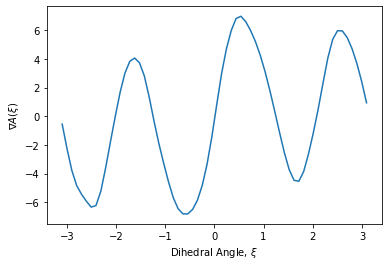

In [16]:
fig, ax = plt.subplots()

ax.set_xlabel(r"Dihedral Angle, $\xi$")
ax.set_ylabel(r"$\nabla A(\xi)$")

ax.plot(xi, dA)
plt.gca()

Finally, we make use of the `pysages.approxfun` module to build a Fourier series approximation to the free energy

In [17]:
from pysages.approxfun import SpectralGradientFit, build_evaluator, build_fitter

fourier_model = SpectralGradientFit(grid)
fourier_fit = build_fitter(fourier_model)
evaluate = build_evaluator(fourier_model)

fun = fourier_fit(dA)
A = evaluate(fun, compute_mesh(grid))
A = A.max() - A

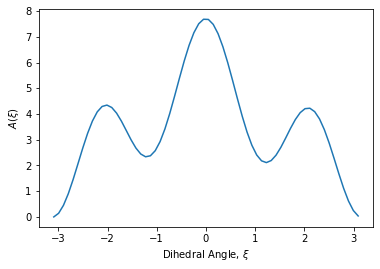

In [18]:
fig, ax = plt.subplots()

ax.set_xlabel(r"Dihedral Angle, $\xi$")
ax.set_ylabel(r"$A(\xi)$")

ax.plot(xi, A)
plt.gca()